   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.9 MB/s eta 0:00:00
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Обучение модели...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.8437 - loss: 0.5451 - val_accuracy: 0.9667 - val_loss: 0.1180
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.9660 - loss: 0.1161 - val_accuracy: 0.9793 - val_loss: 0.0796
Epoch 3/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.9786 - loss: 0.0746 - val_accuracy: 0.9847 - val_loss: 0.0614

Точность на чистых данных: 0.9778

Генерация adversarial примеров...
Точность на adversarial данных: 0.6870
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Примеры оригинальных изображений:


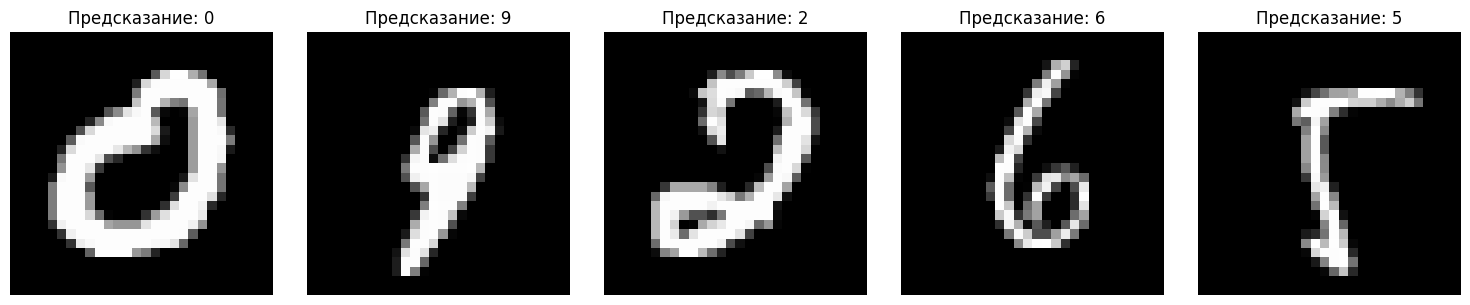


Примеры adversarial изображений:


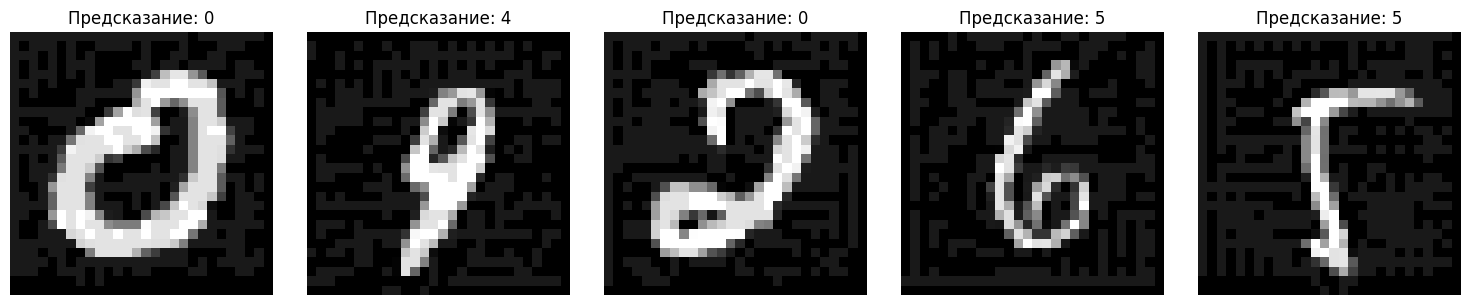


Визуализация возмущений:


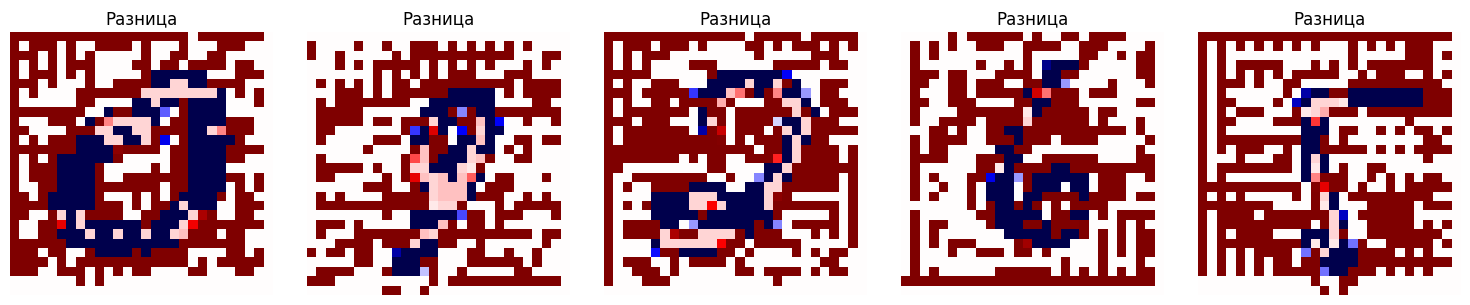


Adversarial Training...
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.6970 - loss: 1.1567 - val_accuracy: 0.9330 - val_loss: 0.2556
Epoch 2/3
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.9375 - loss: 0.2248 - val_accuracy: 0.9610 - val_loss: 0.1725
Epoch 3/3
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9585 - loss: 0.1473 - val_accuracy: 0.9680 - val_loss: 0.1215

Сравнение точности:
Оригинальная модель (чистые данные): 0.9778
Оригинальная модель (adversarial): 0.6870
Защищенная модель (чистые данные): 0.9337
Защищенная модель (adversarial): 0.9510


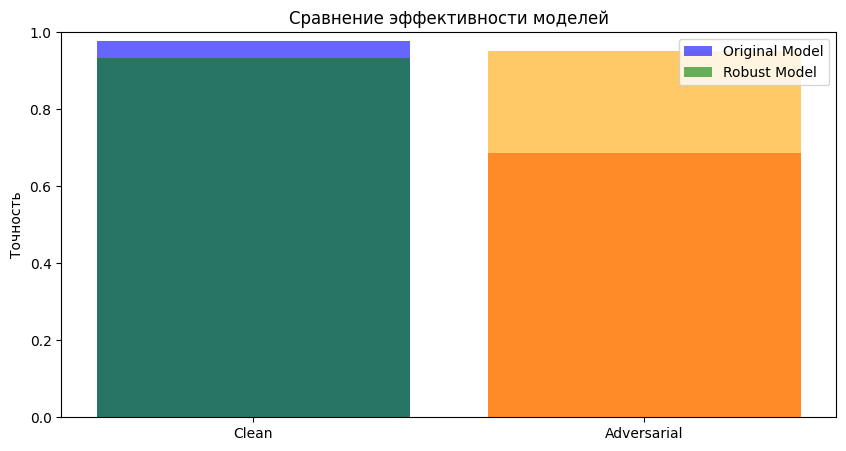

In [2]:

# Установка необходимых пакетов
!pip install adversarial-robustness-toolbox tensorflow matplotlib

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical

# 1. Загрузка и подготовка данных MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# 2. Создание простой CNN модели
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

# 3. Обучение модели
print("Обучение модели...")
model = create_model()
history = model.fit(x_train, y_train,
                   epochs=3,
                   batch_size=128,
                   validation_split=0.1,
                   verbose=1)

# 4. Оценка модели на чистых данных
loss, clean_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"\nТочность на чистых данных: {clean_acc:.4f}")

# 5. Подготовка ART классификатора (совместимый с TF 2.x)
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod

art_classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=10,
    input_shape=(28, 28, 1),
    clip_values=(0, 1),
    loss_object=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    channels_first=False
)

# 6. Создание и применение FGSM атаки
attack_fgsm = FastGradientMethod(estimator=art_classifier, eps=0.1)
print("\nГенерация adversarial примеров...")
x_test_adv = attack_fgsm.generate(x_test[:1000])  # Используем подмножество для скорости

# 7. Оценка на adversarial примерах
loss_adv, adv_acc = model.evaluate(x_test_adv, y_test[:1000], verbose=0)
print(f"Точность на adversarial данных: {adv_acc:.4f}")

# 8. Визуализация результатов
def plot_samples(images, titles, n=5, cmap='gray'):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i].reshape(28, 28), cmap=cmap)
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Выбираем случайные примеры
sample_idx = np.random.choice(len(x_test_adv), 5)

# Предсказания модели
clean_preds = np.argmax(model.predict(x_test[sample_idx]), axis=1)
adv_preds = np.argmax(model.predict(x_test_adv[sample_idx]), axis=1)

print("\nПримеры оригинальных изображений:")
plot_samples(x_test[sample_idx], [f"Предсказание: {p}" for p in clean_preds])

print("\nПримеры adversarial изображений:")
plot_samples(x_test_adv[sample_idx], [f"Предсказание: {p}" for p in adv_preds])

print("\nВизуализация возмущений:")
plot_samples(x_test_adv[sample_idx] - x_test[sample_idx],
            ["Разница"]*5,
            cmap='seismic')

# 9. Adversarial Training (защита)
print("\nAdversarial Training...")
x_train_adv = attack_fgsm.generate(x_train[:5000])  # Малое подмножество для скорости
x_train_mixed = np.concatenate([x_train[:5000], x_train_adv])
y_train_mixed = np.concatenate([y_train[:5000], y_train[:5000]])

model_robust = create_model()
history_robust = model_robust.fit(x_train_mixed, y_train_mixed,
                                epochs=3,
                                batch_size=128,
                                validation_split=0.1,
                                verbose=1)

# 10. Оценка защищенной модели
_, robust_clean_acc = model_robust.evaluate(x_test, y_test, verbose=0)
_, robust_adv_acc = model_robust.evaluate(x_test_adv, y_test[:1000], verbose=0)

print("\nСравнение точности:")
print(f"Оригинальная модель (чистые данные): {clean_acc:.4f}")
print(f"Оригинальная модель (adversarial): {adv_acc:.4f}")
print(f"Защищенная модель (чистые данные): {robust_clean_acc:.4f}")
print(f"Защищенная модель (adversarial): {robust_adv_acc:.4f}")

# 11. Графики сравнения
plt.figure(figsize=(10, 5))
plt.bar(['Clean', 'Adversarial'],
        [clean_acc, adv_acc],
        color=['blue', 'red'],
        alpha=0.6,
        label='Original Model')
plt.bar(['Clean', 'Adversarial'],
        [robust_clean_acc, robust_adv_acc],
        color=['green', 'orange'],
        alpha=0.6,
        label='Robust Model')
plt.title('Сравнение эффективности моделей')
plt.ylabel('Точность')
plt.ylim(0, 1)
plt.legend()
plt.show()